In [ ]:
!pip install yfinance
!pip install keras-tuner --upgrade
!pip install finta

     |████████████████████████████████| 6.4 MB 11.0 MB/s 
     |████████████████████████████████| 63 kB 824 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 98 kB 3.6 MB/s 


In [63]:
# Import Libraries and dependencies
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import yfinance as yf
import keras_tuner as kt
from finta import TA
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, mean_squared_error
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

In [65]:
# Function to pull data and prep it
def yahoo_data(ticker, period, interval):
  #Get Nasdaq 100(^NDX) for 1d from yahoo finance for MAX period.
  df = yf.download(tickers=ticker, period=period, interval=interval)
  df['Actual Returns'] = df['Adj Close'].pct_change()
  return df

# Function to get indicators and concat to df
def get_indicators(df, period, smas, smal):
  # Use Indicators from TA to get trading indicators for stock
  bbands_df = TA.BBANDS(df)
  mfi_df = pd.DataFrame({'MFI':TA.MFI(df)})
  macd_df = TA.MACD(df)
  smas_df = pd.DataFrame({'SMA_Short': TA.SMA(df, period=smal)})
  smal_df = pd.DataFrame({'SMA_Long': TA.SMA(df, period=smas)})
  indicators_list = [bbands_df.columns, mfi_df.columns, macd_df.columns, smas_df.columns, smal_df.columns]
  trading_signals_df = pd.concat([df, bbands_df, mfi_df, macd_df, smas_df, smal_df], axis=1)
  return trading_signals_df, indicators_list
  
# Get buy sell signals for indicators
def get_signals(df, column_name, less_buy_metric, greater_sell_metric):
  df[f'Buy'] = 0.0
  df[f'Sell'] = 0.0
  df.dropna()
  # Repeats buy sell orders
  # Generates Signals for columns buy and sell
  for index, row in df.iterrows():
      if (row[column_name] > greater_sell_metric):
          df.loc[index, f'Buy'] = 1
      elif (row[column_name] < less_buy_metric):
          df.loc[index, f'Sell'] = 1
  return df

# Set up function to overlay entry and exit signals based on specified column and df on the Close Plot
def plot_signals(df, signal):
    plt.figure(figsize=(30, 10))
    plt.plot(df['Close'], c='black', label='Close', alpha=0.5)
    plt.scatter(df.index[df[signal]==-1.0], df[df[signal]==-1.0]['Close'], c='red', label=f'{signal} Exit', marker='v', alpha=0.75)
    plt.scatter(df.index[df[signal]==1.0], df[df[signal]==1.0]['Close'], c='green', label= f'{signal} Entry', marker='^', alpha=0.75)
    plt.xlabel("Date")
    plt.ylabel("Close Prices($)")
    plt.title(f'{signal} Entry/Exit for NASDAQ 100')
    plt.legend(loc='upper right')
    plt.show()

# Find the Strategy Returns for the trading strategy. and visualize comparision of actual vs strategy
def compare_returns(df, signal):
    df['Strategy_Returns'] = df['Actual_Returns'] * df[signal].shift()
    plt.figure(figsize=(15, 5))
    plt.plot(((1 + df['Actual_Returns']).cumprod()), c='black', label='Actual Returns', alpha=0.75)
    plt.plot(((1 + df['Strategy_Returns']).cumprod()), c='red', label='Strategy Returns', alpha=0.75)
    plt.xlabel("Date")
    plt.ylabel("Return (%)")
    plt.title(f'{signal} Strategy Returns Vs Actual Returns for NASDAQ 100')
    plt.legend(loc='upper left')
    plt.show()

# get training and testing set for time series by percent(decimal) for train data
def training_testing_data(df, x_list, y_list, train_pct):
  X = df[x_list].shift().dropna()
  y = df[y_list]
  # Set training start and end dates using DateOffset
  # Set offset in days to offset data 60s*60m*24h then multiply by the percentage of data to use
  offset = round(((int(round(X.index.max().timestamp())) - int(round(X.index.min().timestamp())))/86400)* train_pct)
  training_begin = X.index.min()
  training_end = X.index.min() + DateOffset(days= offset)
  # Set X_train, y_train, X_test, y_test
  X_train = X.loc[training_begin:training_end]
  y_train = y.loc[training_begin:training_end]
  X_test = X.loc[training_end:]
  y_test = y.loc[training_end:]
  return X_train, y_train, X_test, y_test

# Scale data with StandardScaler
def data_SSscaler(train, test):
  scaler = StandardScaler()
  train_scaled = scaler.fit_transform(train)
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

# Scale data with MinMaxScaler
def data_MMscaler(train, test):
  scaler = MinMaxScaler(feature_range=(-1,1))
  train_scaled = scaler.fit_transform(train)
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

# Inverse scaling for a LSTM value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# Creates array from data
def create_threed_array(data, batch):
  # Create data for using the last batch signals worth of trading indicators to predict the signal for the next instance
  X = []
  y = []
  for i in range(batch, len(data)):
      X.append(data[i-batch:i])
      y.append(data[i])
  # Convert data to numpy arrays and then check shape for LSTM(3 dimensional)
  X_array, y_array = np.array(X), np.array(y)
  return X_array, y_array

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate_rsme(lstm, y_raw, y_pred, scaler, offset, batch_size):
	# forecast dataset
	output = lstm.predict(y_pred, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, y_pred[i], yhat)
		# invert differencing
		yhat = yhat + y_raw[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = np.sqrt(mean_squared_error(y_raw[1:], predictions))
	return rmse

# Converts Buy Sell column to single buy sell make sure that when establishing y buy column is first[0] and sell column is second[1]
def prediction_convert(prediction):
  pred_interpreted = []
  for i in range(0, len(prediction)):
    if prediction[i][0] > prediction[i][1]:
      pred_interpreted.append(1)
    elif prediction[i][0] < prediction[i][1]:
      pred_interpreted.append(-1)
    else:
      pred_interpreted.append(0)
  return pred_interpreted

# Evaluates the Accuracy of Models
def evaluate_acc(nn, y_raw, x_pred, batch_size):
  # predicts with dataset
  output = nn.predict(x_pred, batch_size=batch_size)
  pred_df = pd.DataFrame({'Actual': y_raw, 'Predicted':prediction_convert(output)})
  pred_df['Correct'] = (pred_df['Predicted'] == pred_df['Actual'])
  acc = pred_df['Correct'].sum() / pred_df['Correct'].size
  return acc


# Set up the Nueral Network model and train test retrieve rmse
def fit_lstm(x_train, y_train, x_test, y_test, scaler, raw_data, batch_size, nb_epoch):
  lstm = Sequential()
  lstm.add(
      LSTM(
          units= round(((x_train.shape[1] * x_train.shape[2])+y_train.shape[1])*.75),
          activation = 'tanh',
          return_sequences= True, 
          input_shape= (x_train.shape[1], x_train.shape[2])
      ))
  lstm.add(
      Dropout(
          rate= 0.1
      ))
  lstm.add(
      LSTM(
          units= round(((x_train.shape[1] * x_train.shape[2])+y_train.shape[1])*.5), 
          activation = 'tanh', 
          return_sequences= False
      ))
  lstm.add(
      Dropout(
       rate = 0.3   
      ))
  lstm.add(Dense(
      units= round(((x_train.shape[1] * x_train.shape[2])+y_train.shape[1])**.25)
      ))
  lstm.add(Dense(
      units= y_train.shape[1]
    ))
  # Compile the Nueral Network model
  lstm.compile(optimizer='adam', loss='mse')
  # fit model
  train_rmse = []
  test_rmse = []
  for i in range(nb_epoch):
    lstm.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    lstm.reset_states()
		# evaluate model on train data
    raw_train = raw_data[-(len(y_train)+len(y_test)+1):-len(y_test)]
    train_rmse.append(evaluate_rsme(lstm, raw_train, x_train, scaler, 0, batch_size))
    lstm.reset_states()
		# evaluate model on test data
    raw_test = raw_data[-(len(y_test)+1):]
    test_rmse.append(evaluate_rsme(lstm, raw_test, x_test, scaler, 0, batch_size))
    lstm.reset_states()
  history = pd.DataFrame()
  history['y_train'], history['y_test'] = train_rmse, test_rmse
  return history

# Set up the Nueral Network model and train test retrieve acc
def fit_dense(x_train, y_train, x_test, y_test, raw_data, batch_size, nb_epoch):
  nn = Sequential()
  nn.add(Dense(
      units = round((x_train.shape[1] + y_train.shape[1])),
      activation='relu', 
      input_dim= x_train.shape[1]
      ))
  nn.add(Dense(
      units= round((x_train.shape[1] + y_train.shape[1])), 
      activation='relu'
      ))
  nn.add(Dense(
      units= round((x_train.shape[1] + y_train.shape[1])), 
      activation='relu'
      ))
  nn.add(Dense(
      units= y_train.shape[1], 
      activation='sigmoid'
      ))
  # Compile the Nueral Network model
  nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # fit model
  train_acc = []
  test_acc = []
  for i in range(nb_epoch):
    nn.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    nn.reset_states()
		# evaluate model on train data
    raw_train = raw_data[-(len(y_train)+len(y_test)+1):-len(y_test)]
    train_acc.append(evaluate_acc(nn, raw_train, x_train, batch_size))
    nn.reset_states()
		# evaluate model on test data
    raw_test = raw_data[-(len(y_test)+1):]
    test_acc.append(evaluate_acc(nn, raw_test, x_test, batch_size))
    nn.reset_states()
  history = pd.DataFrame()
  history['y_train'], history['y_test'] = train_acc, test_acc
  return history

[*********************100%***********************]  1 of 1 completed


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

0) TrainRMSE=6929.229193, TestRMSE=6232.777153


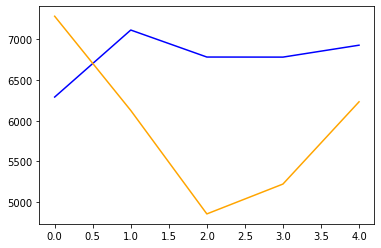

In [66]:
def run():
  ticker = '^NDX'
  period_t = 'MAX'
  interval = '1d'
  df = yahoo_data(ticker, period_t, interval)
  period_i = 20
  smas = 20
  smal = 120
  trading_signals_df, indicator_listd = get_indicators(df, period_i, smas, smal)
  X_list = ['Adj Close']
  y_list = []
  train_pct = .90
  X_train, y_train, X_test, y_test = training_testing_data(trading_signals_df, X_list, y_list, train_pct)
  scaler, X_train_scaled, X_test_scaled = data_MMscaler(X_train, X_test)
  batch = 64
  X_train_array, y_train_array = create_threed_array(X_train_scaled, batch)
  X_test_array, y_test_array = create_threed_array(X_test_scaled, batch)
  raw_data = trading_signals_df['Adj Close'].values
  repeats = 1
  batch_size = 1
  nb_epoch = 5
	# run diagnostic tests
  for i in range(repeats):
    history = fit_lstm(X_train_array, y_train_array, X_test_array, y_test_array, scaler, raw_data, batch_size, nb_epoch)
    pyplot.plot(history['y_train'], color='blue')
    pyplot.plot(history['y_test'], color='orange')
    print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['y_train'].iloc[-1], history['y_test'].iloc[-1]))
  pyplot.savefig('epochs_diagnostic.png')

run()